(log-reg-notebook)=
# Modello di regressione logistica

In questo capitolo, approfondiremo la regressione logistica bivariata, una metodologia statistica che ci consente di analizzare le relazioni tra una variabile di risultato binaria e una singola variabile indipendente. Esploreremo il processo di stima dei coefficienti del modello attraverso un approccio bayesiano, il quale ci offre stime a posteriori più informative e la possibilità di calcolare intervalli di credibilità per tali coefficienti. In aggiunta, forniremo un'interpretazione dei risultati ottenuti dalla regressione logistica. Mostreremo come i coefficienti influenzano la probabilità di successo della variabile binaria di risultato, nonché come interpretare il loro segno e ampiezza. 

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import bambi as bmb
from sklearn.metrics import confusion_matrix

In [4]:
%config InlineBackend.figure_format = 'retina'

RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)

from aquarel import load_theme
theme = load_theme("minimal_light")
theme.apply()
sns.set_palette("colorblind")

## Regressione binomiale

La regressione logistica è utile quando la variabile dipendente è costituita da una serie di successi o fallimenti, cioè una serie di osservazioni 0, 1 derivanti da $n$ prove indipendenti. I dati osservati, quindi, sono una sequenza di valori 0, 1, o, equivalentemente, un insieme di conteggi del numero di successi rispetto al totale delle prove. Potrebbe essere allettante ridurre questi dati a una proporzione, ma non è necessariamente una buona idea. Una proporzione perde informazioni: una proporzione di 0.5 potrebbe corrispondere a 1 successo su 2 prove, o a 4 successi su 4 prove, o a molte altre situazioni, ma queste informazioni sono perdute se ci si concentra esclusivamente sulla proporzione.

La funzione di verosimiglianza appropriata per la regressione binomiale è la distribuzione binomiale:

$$
y_i \sim \text{Binomiale}(n, p_i),
$$

dove 
$y_i$ è il conteggio del numero di successi su $n$ prove, e 
$p_i$ è la probabilità di successo.

Quello che vogliamo ottenere con la regressione binomiale è utilizzare un modello lineare per stimare accuratamente $p_i$ (cioè $p_i = \beta_0 + \beta_1 x_i$). Potremmo cercare di farlo con un termine di verosimiglianza del tipo:

$$
y_i \sim \text{Binomiale}(n, \beta_0 + \beta_1 x_i),
$$

Ma, se facessimo ciò, ci imbatteremmo rapidamente in problemi quando il modello lineare genera valori di $p$ al di fuori dell'intervallo 0--1. Per superare tale ostacolo, dobbiamo adottare un approccio differente: piuttosto che prevedere direttamente il valore atteso della $Y$, prevediamo il valore atteso di una sua trasformazione. Nella regressione logistica, la funzione link utilizzata è il logit, il logaritmo del rapporto delle probabilità, espresso come:

$$
\log \left( \frac{\pi}{1-\pi} \right)
$$

dove $\pi$ rappresenta la probabilità che $Y$ assuma il valore 1.

Il logit può variare tra meno infinito e più infinito, rendendo il modello di regressione logistica appropriato per dati con variabili di tipo Bernoulliano. Di conseguenza, la regressione logistica è, in essenza, una forma di regressione lineare che si concentra sulla previsione della trasformazione della variabile Bernoulliana $Y$, utilizzando il logaritmo del rapporto delle probabilità come [funzione link](https://it.wikipedia.org/wiki/Logit).

La figura seguente offre una rappresentazione visiva di questi concetti. Nel pannello sinistro, viene mostrata la relazione tra le probabilità e un predittore $X$. È evidente che un modello lineare non sia adeguato, in quanto la relazione tra $Y$ e $X$ non segue un andamento lineare ed è confinata tra 0 e 1. Nel pannello centrale, vediamo il comportamento degli odds in relazione a $X$. In questa situazione, il vincolo di valori compresi tra 0 e 1 non è più presente, ma la relazione rimane non lineare, rendendo il modello lineare inappropriato. Infine, nel pannello destro, il logit varia da meno infinito a più infinito ed è linearmente correlato con $X$. Pertanto, in questo contesto specifico, l'utilizzo di un modello lineare risulta appropriato.

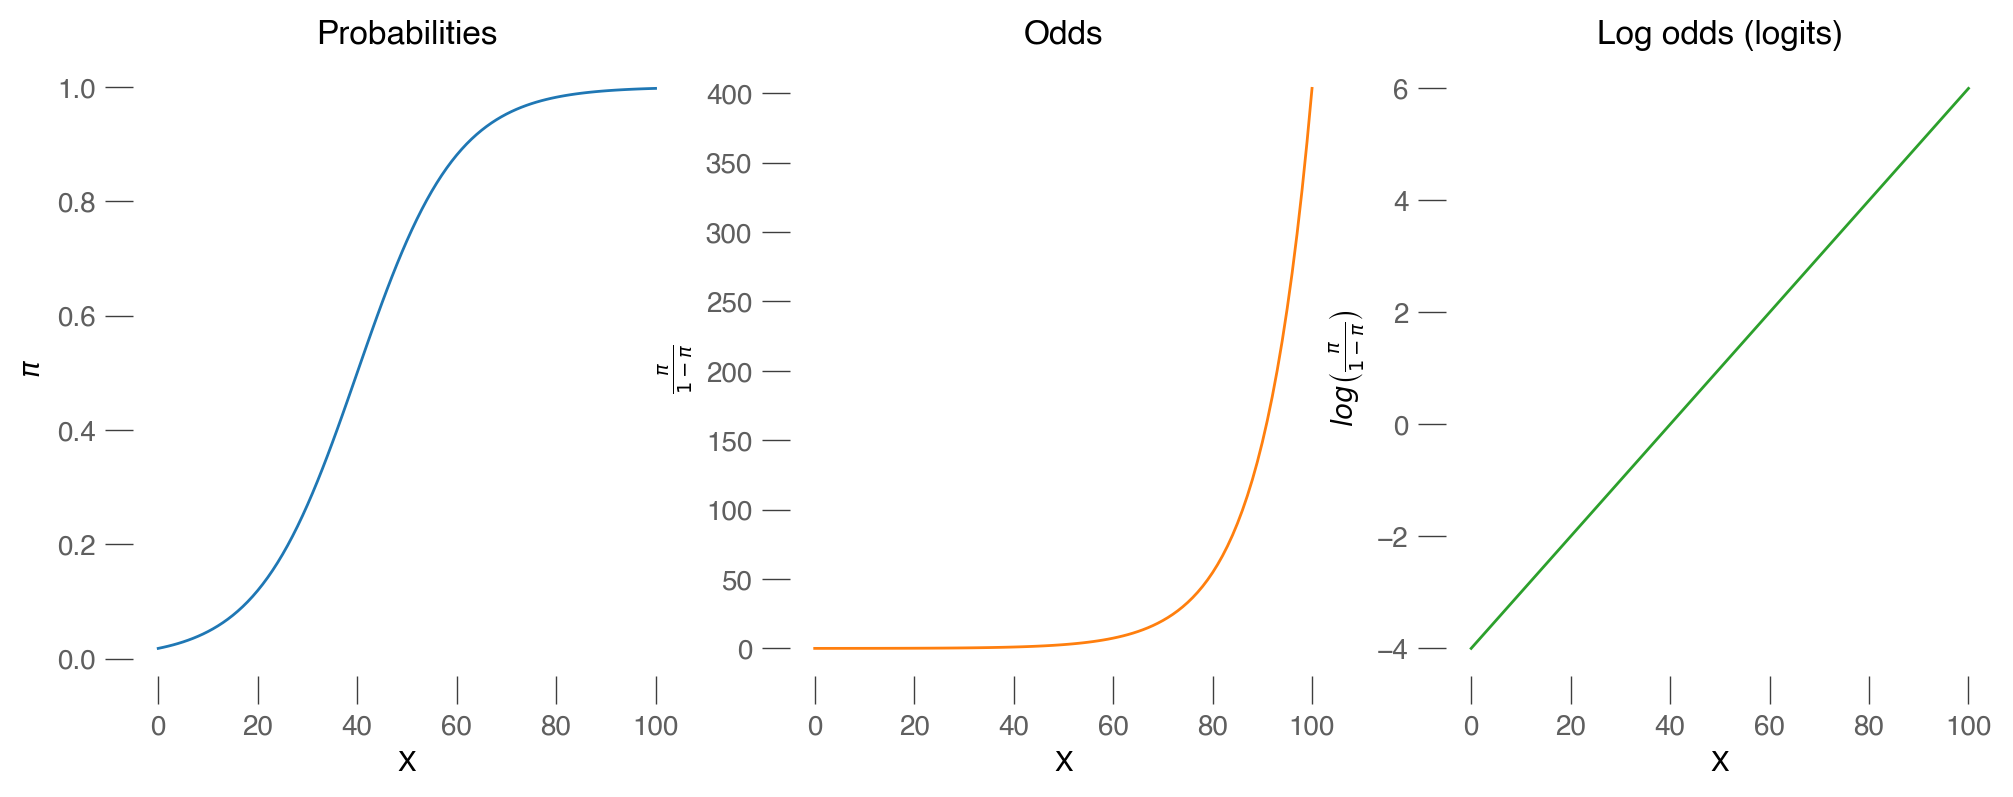

In [6]:
x = np.linspace(0, 100, num=101)
logits = np.linspace(-4, 6, num=101)
odds = np.exp(logits)
probs = 1 / (1 + np.exp(-logits))

plt.figure(figsize=(12, 4))

plt.subplot(131)
plt.plot(x, probs, color="tab:blue", linewidth=1)
plt.title("Probabilities")
plt.xlabel("X")
plt.ylabel(r"$\pi$")

plt.subplot(132)
plt.plot(x, odds, color="tab:orange", linewidth=1)
plt.title("Odds")
plt.xlabel("X")
plt.ylabel(r"$\frac{\pi}{1 - \pi}$")

plt.subplot(133)
plt.plot(x, logits, color="tab:green", linewidth=1)
plt.title("Log odds (logits)")
plt.xlabel("X")
plt.ylabel(r"$log \left( \frac{\pi}{1 - \pi} \right)$");

Quindi, invece di modellare direttamente la probabilità $\pi$, modelliamo una funzione della probabilità con un modello lineare. La funzione che scegliamo è la funzione Logit. In questo contesto, il logit viene chiamato funzione di collegamento (*link function*). Può essere considerata una trasformazione che mappa proporzioni nell'intervallo (0--1) al dominio ($-\infty, +\infty$). Esistono diverse funzioni che potrebbero essere utilizzate, ma la [funzione Logit](https://it.wikipedia.org/wiki/Logit) è la più comune.

L'inversione della funzione di collegamento ci permette di esprimere il modello direttamente in termini di probabilità. In questo modo otteniamo un modello non lineare, ovvero la [funzione sigmoidea](https://it.wikipedia.org/wiki/Funzione_sigmoidea):

$$
\pi = \frac{e^\eta}{1 + e^\eta} = \frac{1}{1 + e^{-\eta}}.
$$

dove $\eta = \beta_0 + \beta_1 x_i$.

Questa formulazione trasforma la probabilità in una forma non lineare.

Nel contesto della regressione logistica, i coefficienti del modello vengono stimati utilizzando un modello lineare che coinvolge i logit. Tuttavia, la formulazione precedentemente esposta del modello di regressione logistica, in cui la probabilità $\pi$ è espressa come una funzione non lineare di $\eta$, trova impiego nella creazione di una rappresentazione grafica intuitiva della relazione tra la probabilità che $Y$ assuma il valore 1 e il predittore $X$. Questa rappresentazione visiva agevola la comprensione della natura non lineare del modello logistico e delle relazioni sottostanti.

In sintesi, la regressione logistica permette di modellare la probabilità di successo attraverso una trasformazione che tiene conto della natura binaria dei dati, garantendo che le stime della probabilità rimangano nell'intervallo appropriato, e offrendo una struttura flessibile per descrivere relazioni complesse tra variabili.

## Un esempio concreto

Esaminiamo ora come eseguire la regressione logistica con PyMC. 

## American National Election Studies (ANES)

In questo tutorial, utilizzeremo un set di dati forniti dal sito di Bambi per illustrare il modello di regressione logistica. Questi dati provengono dallo studio pilota del 2016. Lo studio completo includeva 1200 persone, ma in questo caso, è stato selezionato un sottoinsieme di 487 persone che hanno risposto a una domanda riguardante se avrebbero votato per Hillary Clinton o Donald Trump.

Importiamo i dati.

In [7]:
data = bmb.load_data("ANES")
data.head()

,vote,age,party_id
0,clinton,56,democrat
1,trump,65,republican
2,clinton,80,democrat
3,trump,38,republican
4,trump,60,republican


La nostra variabile di esito è `vote`, che indica le risposte delle persone alla seguente domanda:

> If the 2016 presidential election were between Hillary Clinton for the Democrats and Donald Trump for the Republicans, would you vote for Hillary Clinton, Donald Trump, someone else, or probably not vote?

Esaminiamo la distribuzione di frequenze della variabile `vote`.

In [8]:
data["vote"].value_counts()

vote
clinton         215
trump           158
someone_else     48
Name: count, dtype: int64

Per semplificare l'analisi, qui considereremo solo le risposte `Clinton` e `Trump`. Ci porremo il problema di modellare la probabilità di voto per Clinton.

In [9]:
clinton_data = data.loc[data["vote"].isin(["clinton", "trump"]), :]
clinton_data.head()

,vote,age,party_id
0,clinton,56,democrat
1,trump,65,republican
2,clinton,80,democrat
3,trump,38,republican
4,trump,60,republican


## Specificare e adattare il modello in Bambi

Nel nostro esempio, utilizzeremo il modello di regressione logistica per stimare la probabilità di votare per Clinton in funzione dell'età. Il nostro obiettivo è quindi modellare $\pi = P(Y = 1)$, ovvero la probabilità di votare per Clinton, utilizzando l'età come variabile esplicativa.

La regressione logistica collega il logit di $\pi$ a un predittore o a una combinazione lineare di predittori. Nella nostra situazione, l'equazione matematica del nostro modello sarà dunque la seguente:

$$
\log{\left(\frac{\pi}{1 - \pi}\right)} = \beta_0 + \beta_1 X,
$$

dove $X$ rappresenta l'età.

Inoltre, per utilizzare l'approccio bayesiano, dobbiamo specificare una distribuzione a priori per i parametri e una funzione di verosimiglianza. Nella nostra analisi, utilizzeremo le distribuzioni a priori predefinite di Bambi e la verosimiglianza sarà il prodotto delle prove Bernoulliane, ovvero il prodotto delle probabilità

$$
\prod_{i=1}^{n}{p_i^{y_i}(1-p_i)^{1-y_i}},
$$

dove $p_i = P(Y=1)$ e $y_i = 1$ se l'intenzione di voto è per Clinton e $y_i = 0$ se è per Trump.

La specificazione e l'adattamento del modello si rivelano semplici e intuitivi attraverso l'uso di Bambi. Per sfruttare le capacità di Bambi, è sufficiente formulare il modello seguendo la sintassi delle formule {cite:p}`wilkinson1973symbolic` e fornire il corretto argomento `family`. È da notare l'uso di una sintassi opzionale sul lato sinistro della formula: `vote[clinton]` comunica a Bambi l'intenzione di modellare la probabilità di `vote=='clinton'`, anziché quella di `vote=='trump'`.

Sul lato destro della formula, utilizziamo il termine `age` per indicare a Bambi la nostra intenzione di considerare solamente la variabile esplicativa `age` nel modello.

In [10]:
clinton_model = bmb.Model(
    "vote['clinton'] ~ age", clinton_data, family="bernoulli"
)

Procediamo ora con il campionamento. L'argomento opzionale `idata_kwargs={"log_likelihood": True}` richiede il calcolo del logaritmo della verosimiglianza (log-likelihood) durante l'adattamento. Questo passaggio è rischiesto per potere utilizzare in seguito varie funzioni che valutano quanto bene il modello si adatta ai dati.

In [12]:
clinton_fitted = clinton_model.fit(
    method="nuts_numpyro", idata_kwargs={"log_likelihood": True}
)

/Users/corrado/mambaforge/envs/pymc_env/lib/python3.11/site-packages/bambi/models.py:307: FutureWarning: the method argument has been deprecated, please use inference_method
  warnings.warn(
Modeling the probability that vote==clinton
/Users/corrado/mambaforge/envs/pymc_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Compiling...
Compilation time =  0:00:00.999930
Sampling...


Compiling.. :   0%|          | 0/2000 [00:00<?, ?it/s]






Running chain 0:   0%|          | 0/2000 [00:03<?, ?it/s]



Running chain 3: 100%|██████████| 2000/2000 [00:03<00:00, 594.47it/s]  


Sampling time =  0:00:03.693006
Transforming variables...
Transformation time =  0:00:00.005209
Computing Log Likelihood...
Log Likelihood time =  0:00:00.590079


Possiamo stampare l'oggetto `clinton_model` per visualizzare informazioni sulla distribuzione della risposta, la funzione link e le distribuzioni a priori.

In [13]:
clinton_model

       Formula: vote['clinton'] ~ age
        Family: bernoulli
          Link: p = logit
  Observations: 373
        Priors: 
    target = p
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 7.586)
            age ~ Normal(mu: 0.0, sigma: 0.1454)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

Otteniamo una rappresentazione delle distribuzioni a priori usate da Bambi.

Sampling: [Intercept, age]


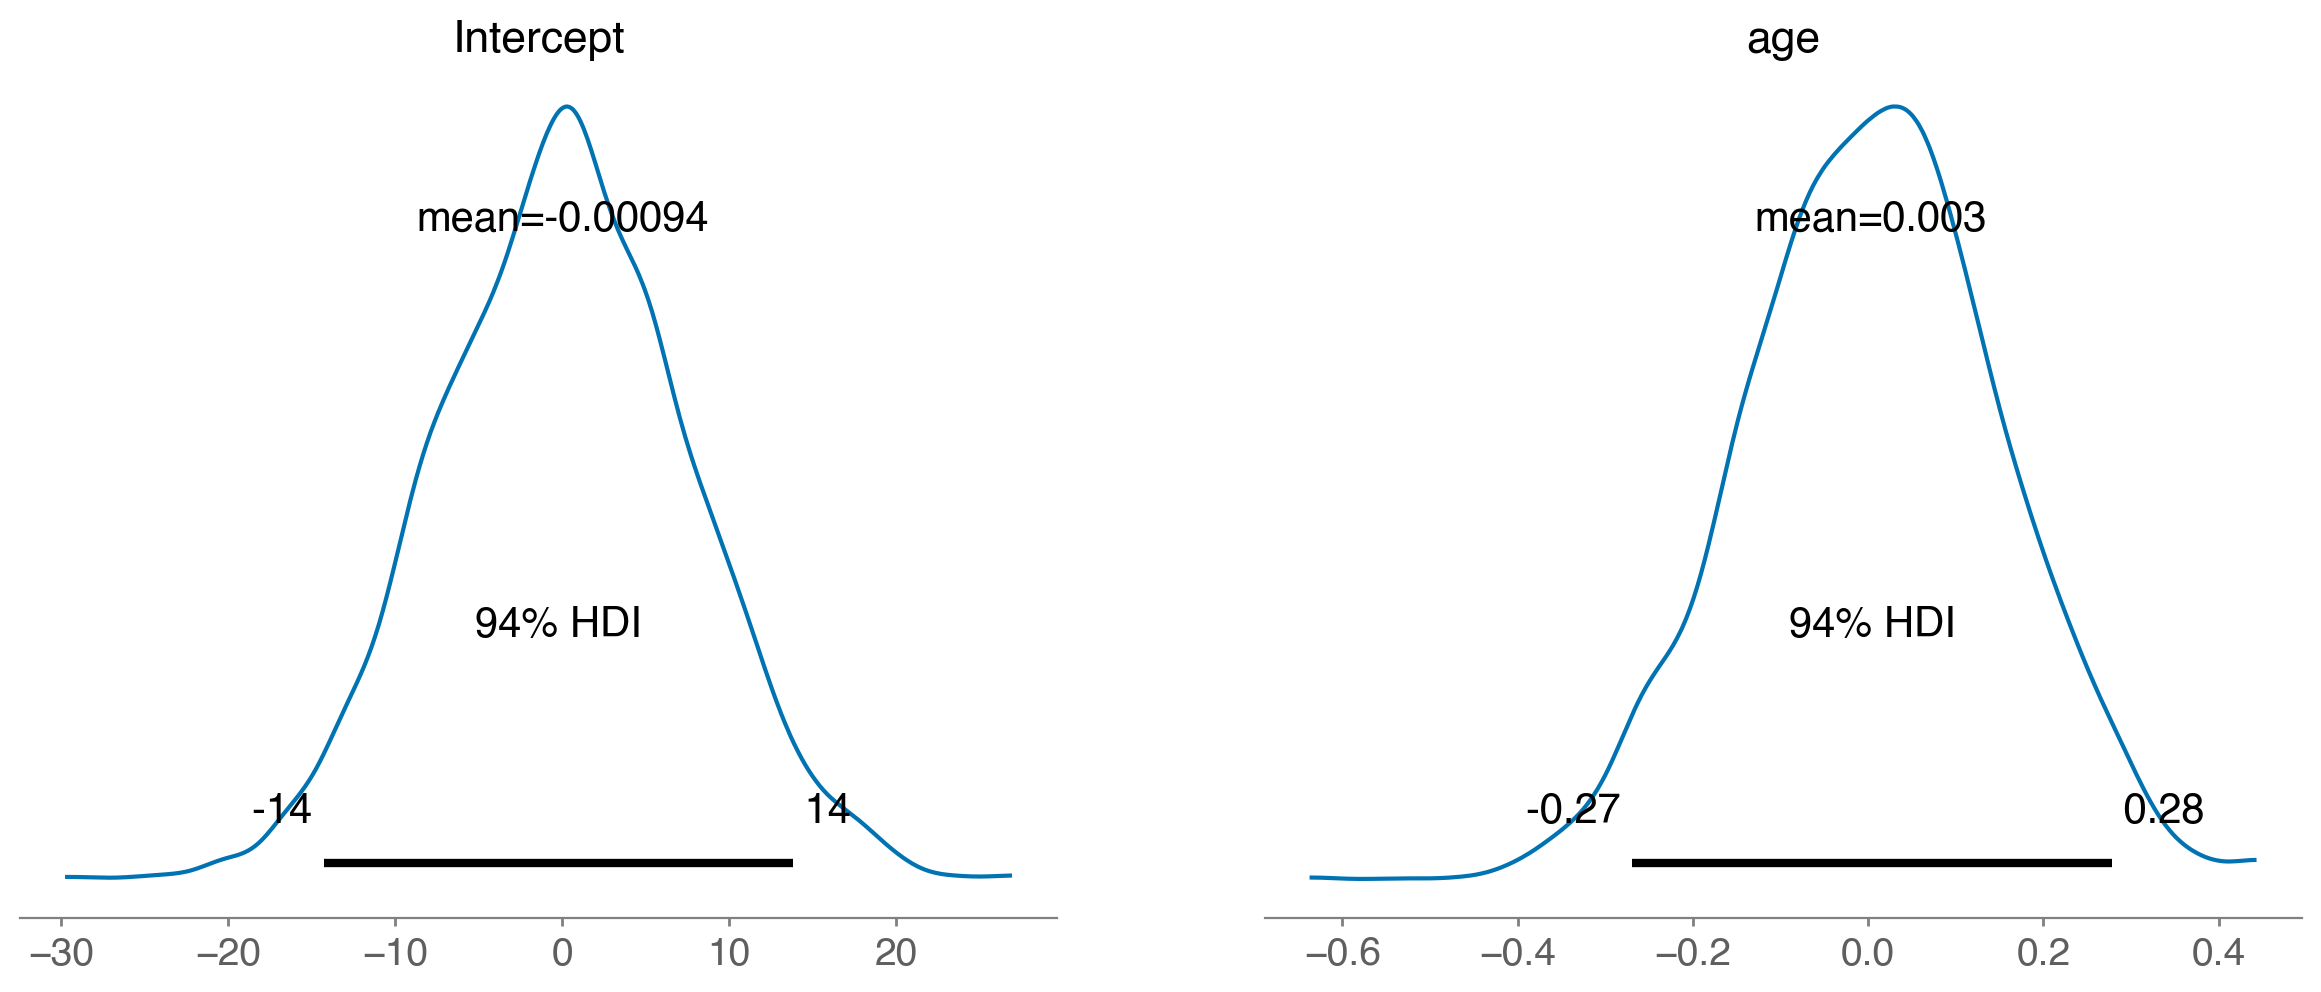

In [14]:
clinton_model.plot_priors();

## Valutazione del modello

Esaminiamo i trace plot delle distribuzioni a posteriori dei parametri.

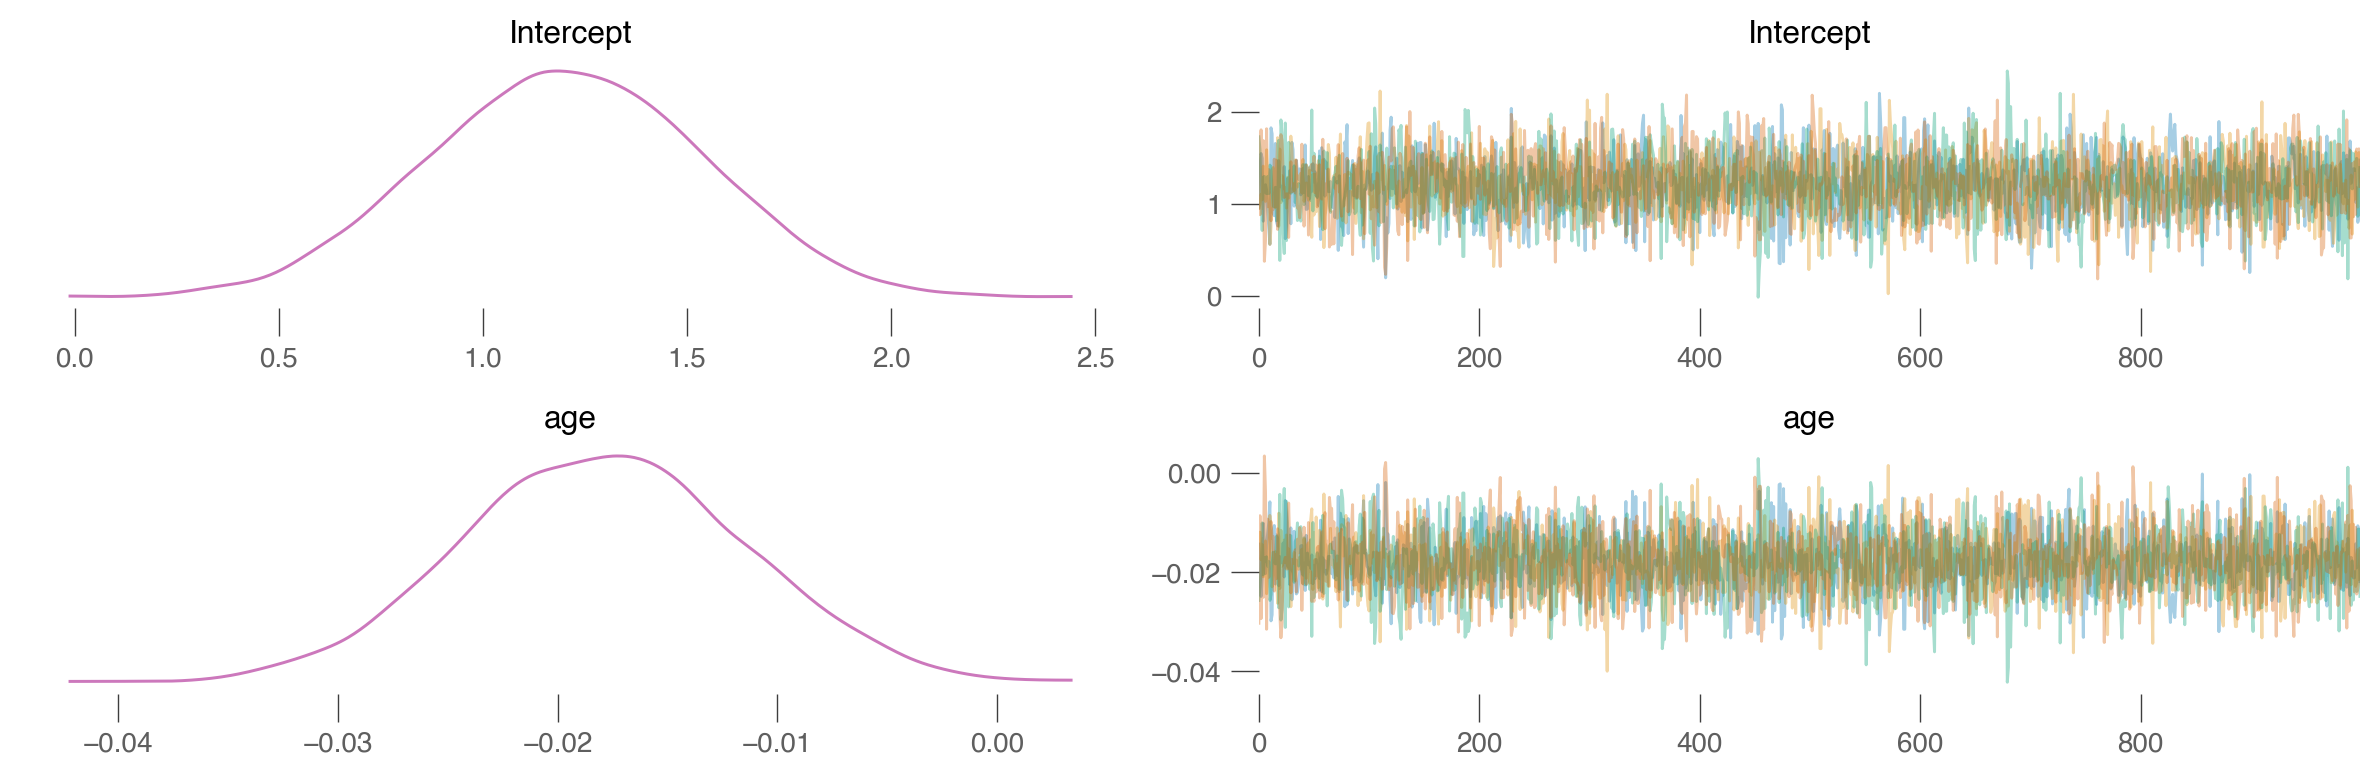

In [16]:
az.plot_trace(clinton_fitted, combined=True, compact=False)
plt.tight_layout()

### Posterior Predictive Check

Generiamo le previsioni posteriori dal modello di regressione logistica bivariata adattato ai dati di voto per Clinton. Il parametro `clinton_fitted` rappresenta l'output dell'adattamento del modello, che contiene le stime posteriori dei parametri del modello. Il parametro `kind="pps"` indica il tipo di previsione che vogliamo ottenere, nel caso specifico "pps" sta per "posterior predictive samples" (campioni predittivi posteriori). Questo significa che stiamo generando campioni casuali da una distribuzione predittiva basata sui parametri stimati e sulle distribuzioni a posteriori. In altre parole, stiamo simulando possibili risultati futuri o predizioni che potrebbero verificarsi dato il modello adattato ai dati.

In [17]:
posterior_predictive = clinton_model.predict(clinton_fitted, kind="pps")

Otteniamo il Posterior Preditive Check.

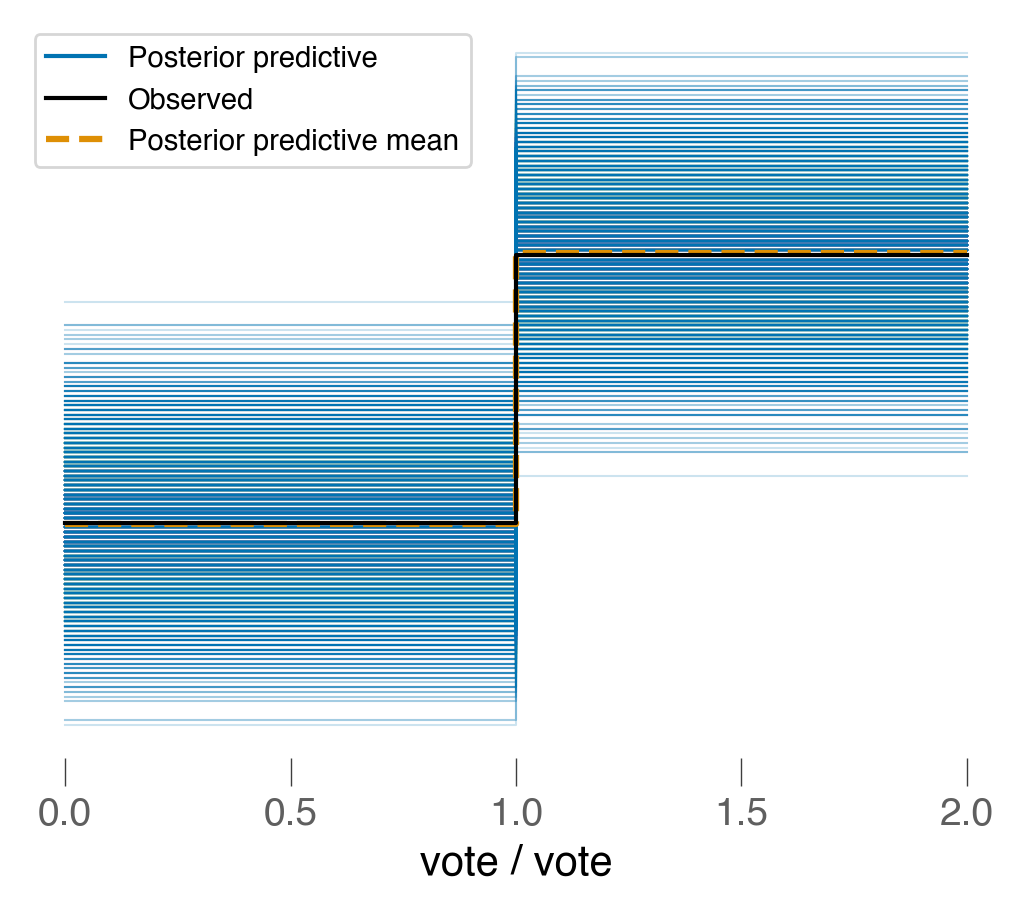

In [18]:
az.plot_ppc(clinton_fitted);

I possibili risultati futuri sono coerenti con i dati osservati, il che fornisce evidenze di un buon adattamento del modello.

## Parametro $\hat \kappa$

Possiamo utilizzare anche ArviZ per calcolare [LOO](https://arxiv.org/abs/1507.04544) e individuare le osservazioni che hanno un impatto significativo, basandoci sul valore stimato del parametro $\hat \kappa$. 

In [19]:
loo = az.loo(clinton_fitted, pointwise=True)

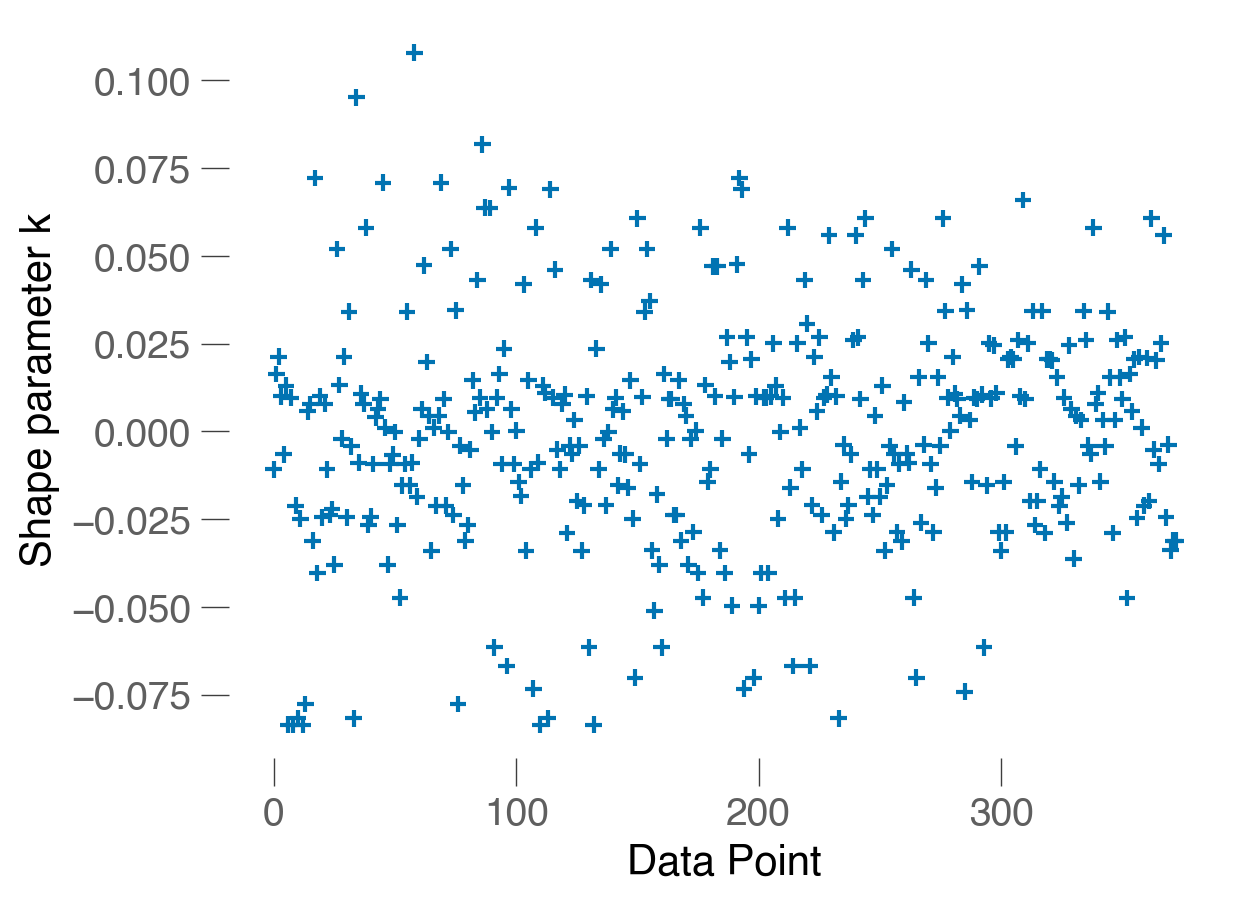

In [20]:
az.plot_khat(loo.pareto_k);

L'andamento dei valori di $\hat \kappa$ nel grafico evidenzia che la maggior parte di essi è concentrata in un intervallo che arriva approssimativamente fino a 0.05. Oltre questo valore, si notano solo pochi punti che si discostano. Questa distribuzione non suggerisce la presenza di osservazioni particolarmente influenti, il che indica che il modello si adatta bene ai dati.

## Inferenza

Esaminiamo una sintesi delle distribuzioni a posteriori dei parametri.

In [21]:
az.summary(clinton_fitted)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.203,0.335,0.590,1.829,0.006,0.004,3577.0,2444.0,1.0
age,-0.018,0.006,-0.029,-0.005,0.000,0.000,3948.0,2727.0,1.0
vote_mean[0],0.549,0.028,0.499,0.603,0.001,0.000,2547.0,2516.0,1.0
vote_mean[1],0.509,0.036,0.441,0.573,0.001,0.000,3039.0,2453.0,1.0
vote_mean[2],0.443,0.054,0.348,0.546,0.001,0.001,3571.0,2526.0,1.0
...,...,...,...,...,...,...,...,...,...
vote_mean[368],0.606,0.027,0.555,0.656,0.001,0.000,2443.0,2306.0,1.0
vote_mean[369],0.593,0.026,0.548,0.645,0.001,0.000,2370.0,2462.0,1.0
vote_mean[370],0.514,0.035,0.448,0.576,0.001,0.000,2987.0,2458.0,1.0
vote_mean[371],0.623,0.030,0.567,0.676,0.001,0.000,2591.0,2421.0,1.0


### Interpretazione dei coefficienti nella regressione logistica

Sulla base delle distribuzioni a posteriori dei parametri, possiamo scrivere l'equazione del modello di regressione logistica nel modo seguente:

$$
\log{\left(\frac{\pi}{1 - \pi}\right)} = 1.195 - 0.018 \cdot \text{età}.
$$

### Interpretazione di $\beta_0$

Quando il predittore $X$ è pari a 0, $\beta_0$ rappresenta il logit dell'evento di interesse (voto per Clinton) e $e^{\beta_0}$ rappresenta gli odds di successo ($\pi / (1-\pi)$).

Nel caso presente, dunque, per un'età pari a 0, gli odds di successo ($\pi / (1-\pi)$) sono pari a

In [22]:
np.exp(1.195)

3.3035577705016714

e la probabilità di un voto per Clinton è

In [23]:
np.exp(1.195) / (1 + np.exp(1.195))

0.7676341173216252

Tuttavia, nel caso presente, l'intercetta non fornisce informazioni utili. Se avessimo trasformato i dati codificando l'età come scarti dalla media, le interpretazioni precedenti sarebbero riferite all'età media del campione, il che avrebbe più senso.

### Interpretazione di $\beta_1$

Quando $X$ aumenta di 1, da $x$ a $x+1$, $\beta_1$ rappresenta il cambiamento tipico nel logit, e $e^{\beta_1}$ rappresenta il cambiamento tipico moltiplicativo negli odds:

$$
\beta_1 = \log(\text{odds}_{x+1}) - \log(\text{odds}_x) \quad \text{e} \quad e^{\beta_1} = \frac{\text{odds}_{x+1}}{\text{odds}_x}.
$$

In altre parole, sulla scala lineare dei logit, il coefficiente $\beta_1$ rappresenta semplicemente la pendenza: per un cambiamento unitario dell'età, i logit del voto per Clinton diminuiscono di -0.018. 

Tuttavia, è più facile interpretare questo risultato sulla scala non lineare degli odds, dove questa variazione è moltiplicativa: per ogni anno di aumento dell'età, gli odds stimati dell'evento (votare per Clinton) vengono moltiplicati per $e^{\beta_1}$:

In [24]:
np.exp(-0.018)

0.9821610323583008

Poiché la relazione di probabilità è una curva sigmoidale, non possiamo interpretare facilmente il coefficiente $\beta_1$ su questa scala. È invece preferibile rappresentare graficamente come varia la probabilità attesa di "successo" al variare dell'età. La rappresentazione di questa relazione, basata sulle stime a posteriori del modello, è fornita di seguito.

In [25]:
age = np.arange(18, 91)
new_data = pd.DataFrame({
    "age": np.tile(age, 3)
})
new_data

,age
0,18
1,19
2,20
3,21
4,22
...,...
214,86
215,87
216,88
217,89


In [26]:
clinton_model.predict(clinton_fitted, data=new_data)

In [27]:
vote_posterior = az.extract(clinton_fitted, num_samples=2000)["vote_mean"]
vote_posterior.shape

(219, 2000)

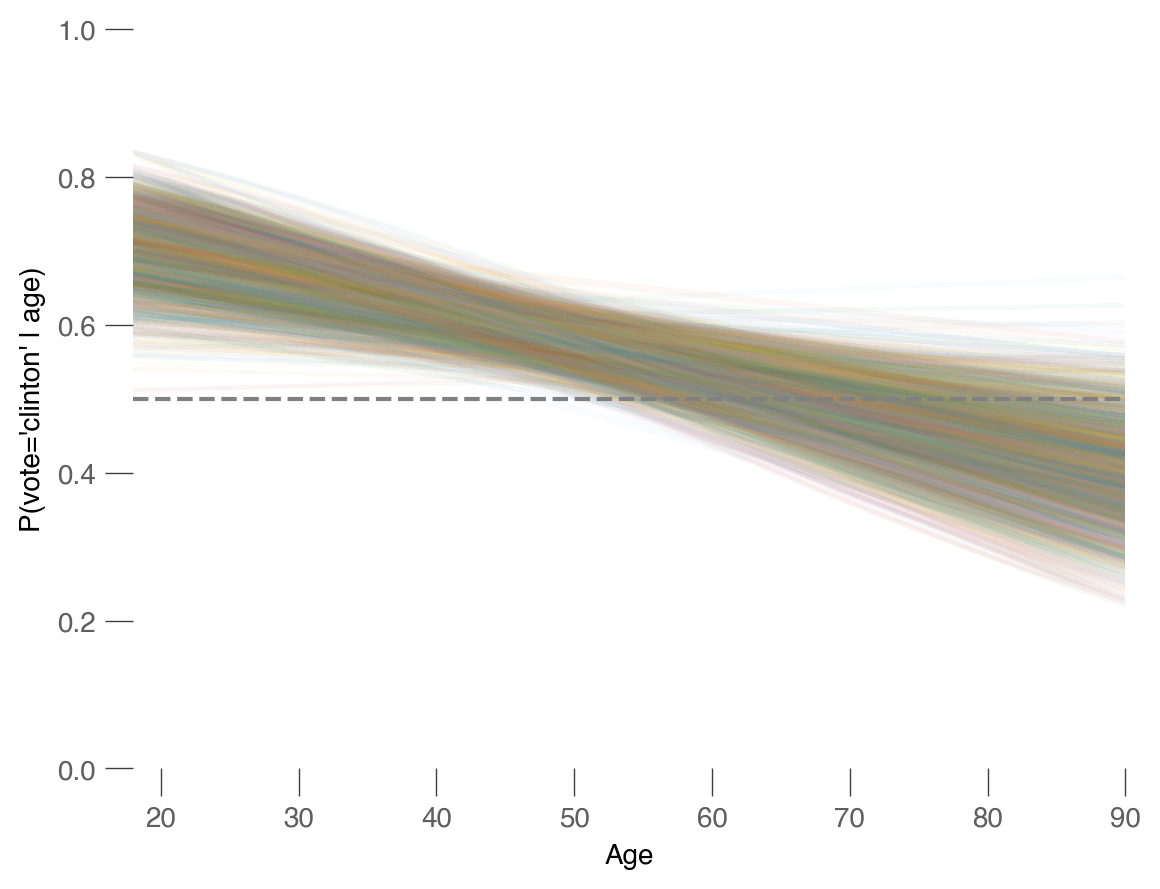

In [28]:
plt.plot(new_data.age, vote_posterior, alpha=0.04)

# Adding a dashed horizontal line at y=0.5 (50% probability)
plt.axhline(y=0.5, color="gray", linestyle="dashed")

plt.ylabel("P(vote='clinton' | age)")
plt.xlabel("Age")
plt.ylim(0, 1)
plt.xlim(18, 90);

Possiamo interpretare il grafico precedente nel seguente modo: fino a circa 65 anni, l'intenzione di voto per Clinton è maggiore dell'intenzione di voto per Trump; dopo i 65 anni, la situazione si inverte.

Il fatto che la figura riporti molteplici curve (2000 nel caso presente) ci informa sull'incertezza a posteriori delle predizioni del modello.

## Accuratezza delle classificazioni a posteriori

Esaminiamo ora la precisione delle nostre classificazioni posteriori. Nell'ambito della regressione, quando affrontiamo una variabile quantitativa  $Y$, abbiamo risposto a questa domanda analizzando la tipica differenza tra $Y$ e le sue previsioni posteriori. Tuttavia, nel contesto della classificazione con una variabile $Y$ categorica, le nostre classificazioni posteriori binarie di $Y$ possono essere corrette oppure errate. Pertanto, possiamo calcolare un indicatore globale di precisione.

Per procedere con il calcolo, il primo passo è determinare la probabilità a posteriori $P(Y = 1 | X)$, ovvero la probabilità che ciascuna osservazione rappresenti un voto per Clinton, per ogni singola osservazione.

Calcoliamo le probabilità predette dai coefficienti a posteriori del modello:

In [29]:
clinton_model.predict(clinton_fitted)

Le probabilità a posteriori possono essere estratte dall'oggetto `clinton_model` nel modo seguente.

In [30]:
print(clinton_fitted.posterior["vote_mean"])

<xarray.DataArray 'vote_mean' (chain: 4, draw: 1000, vote_obs: 373)>
array([[[0.5375756 , 0.50531666, 0.45158615, ..., 0.50890811,
         0.59745097, 0.59745097],
        [0.54675708, 0.49846173, 0.41847531, ..., 0.50384302,
         0.6349495 , 0.6349495 ],
        [0.53756401, 0.48157985, 0.38996245, ..., 0.4878032 ,
         0.63971559, 0.63971559],
        ...,
        [0.55011225, 0.52623864, 0.48623576, ..., 0.52889922,
         0.59449903, 0.59449903],
        [0.5470223 , 0.52009394, 0.47503072, ..., 0.52309464,
         0.5970231 , 0.5970231 ],
        [0.56188043, 0.51291638, 0.43122458, ..., 0.51838652,
         0.65047673, 0.65047673]],

       [[0.5695976 , 0.54291844, 0.49797754, ..., 0.54589786,
         0.61879144, 0.61879144],
        [0.57942433, 0.55293317, 0.50818087, ..., 0.55589438,
         0.6281263 , 0.6281263 ],
        [0.53074081, 0.49137045, 0.42622861, ..., 0.49574859,
         0.60369459, 0.60369459],
...
        [0.55607605, 0.53055854, 0.48773866, ...

Otteniamo così un array multidimensionale di dimensioni avente le seguenti dimensioni: chain: 4, draw: 1000, vote_obs: 373. Vogliamo la media a posteriori per ciascuna osservazione, ovvero vogliamo ridurre l'array precedente ad un vettore di 373 elementi. A questo fine possiamo procedere come indicato di seguito.

In [31]:
probs_array = clinton_fitted.posterior["vote_mean"]
average_posterior_values = probs_array.mean(dim=("chain", "draw"))
clinton_data["probs"] = average_posterior_values.values
clinton_data.head()

/var/folders/hl/dt523djx7_q7xjrthzjpdvc40000gn/T/ipykernel_90682/211204809.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clinton_data["probs"] = average_posterior_values.values


,vote,age,party_id,probs
0,clinton,56,democrat,0.549265
1,trump,65,republican,0.509170
2,clinton,80,democrat,0.442875
3,trump,38,republican,0.626937
4,trump,60,republican,0.531480


Creaiamo la variabile `predicted` che assume il valore 1 se la probabilità di un'osservazione è maggiore di 0.5 e 0 altrimenti.

In [32]:
clinton_data["predicted"] = (clinton_data["probs"] > 0.5).astype(int);

/var/folders/hl/dt523djx7_q7xjrthzjpdvc40000gn/T/ipykernel_90682/3766605128.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clinton_data["predicted"] = (clinton_data["probs"] > 0.5).astype(int);


Classifichiamo le osservazioni ricodificando il voto "clinton" con 1 e 0 altrimenti.

In [33]:
clinton_data["actual"] = (clinton_data["vote"] == "clinton").astype(int)

/var/folders/hl/dt523djx7_q7xjrthzjpdvc40000gn/T/ipykernel_90682/2438354139.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clinton_data["actual"] = (clinton_data["vote"] == "clinton").astype(int)


Creiamo una matrice di confusione.

In [34]:
confusion = confusion_matrix(clinton_data["actual"], clinton_data["predicted"])
print(confusion)

[[ 28 130]
 [ 27 188]]


### Sensibilità, specificità e accuratezza complessiva del modello

Consideriamo $ Y $ come un insieme di $ n $ etichette binarie vere per i dati osservati e $ \hat{Y} $ come il set di etichette previste dal modello di classificazione. Possiamo utilizzare una matrice di confusione per riassumere la performance del modello confrontando le etichette vere con quelle predette. In questa matrice, la somma $ a + b + c + d $ è uguale al numero totale $ n $ di osservazioni.

- $ a $: Veri Negativi (TN) - Entrambe le etichette, reale e prevista, sono 0.
- $ b $: Falsi Positivi (FP) - L'etichetta reale è 0, mentre l'etichetta prevista è 1.
- $ c $: Falsi Negativi (FN) - L'etichetta reale è 1, mentre l'etichetta prevista è 0.
- $ d $: Veri Positivi (TP) - Entrambe le etichette, reale e prevista, sono 1.

|           | $ \hat{Y} = 0 $  | $ \hat{Y} = 1 $  |
|-----------|--------------------|--------------------|
| $ Y = 0 $| $ a $ (TN)       | $ b $ (FP)       |
| $ Y = 1 $| $ c $ (FN)       | $ d $ (TP)       |

L'**Accuratezza Complessiva** fornisce una misura della proporzione di etichette vere che il modello è riuscito a classificare correttamente:

$$
\text{Accuratezza Complessiva} = \frac{a + d}{a + b + c + d}
$$

**Sensibilità** e **Specificità** sono altre due metriche importanti:

- La **Sensibilità** (o Tasso di Veri Positivi) rappresenta la proporzione di osservazioni positive $ Y = 1 $ che sono state correttamente identificate dal modello:

$$
\text{Sensibilità} = \frac{d}{c + d}
$$

- La **Specificità** (o Tasso di Veri Negativi) rappresenta la proporzione di osservazioni negative $ Y = 0 $ che sono state correttamente identificate dal modello:

$$
\text{Specificità} = \frac{a}{a + b}
$$

Queste metriche forniscono una visione completa delle performance del modello di classificazione.

Per i dati presenti abbiamo un'accuratezza complessiva di

In [30]:
(33 + 184) / (33 + 125 + 31 + 184)

0.5817694369973191

Abbiamo una sensibilità di

In [31]:
184/ (31+184)

0.8558139534883721

e una specificità di

In [32]:
33 / (33+125)

0.2088607594936709

I risultati indicano che il modello ha una capacità predittiva molto limitata, soprattutto se consideriamo la sua specificità. È evidente che è stato troppo ambizioso tentare di predire le intenzioni di voto basandosi unicamente sull'età. Questo tutorial rappresenta una versione semplificata dell'esempio discusso nel sito di Bambi, dove, oltre all'età, viene utilizzata anche l'appartenenza a un partito politico come predittore. In quel contesto, è chiaro che l'intenzione di voto può essere prevista con una precisione maggiore. Nell'esempio attuale, a fini didattici, abbiamo volutamente semplificato il modello per avere un unico predittore.

## Funzione logistica

Per chi fosse interessato, possiamo esaminare i passaggi algebrici che che trasformano l'equazione iniziale $\log{\left(\frac{\pi}{1 - \pi}\right)} = \beta_0 + \beta_1 X$ nell'equazione $\pi = \frac{e^\eta}{1 + e^\eta}$.

Partiamo dall'equazione iniziale:

   $$\log{\left(\frac{\pi}{1 - \pi}\right)} = \beta_0 + \beta_1 X.$$
   
Applichiamo la funzione esponenziale ad entrambi i lati dell'equazione per eliminare il logaritmo:

   $$\exp\left(\log{\left(\frac{\pi}{1 - \pi}\right)}\right) = \exp(\beta_0 + \beta_1 X).$$

Utilizziamo la proprietà $\exp(\log(a)) = a$ per semplificare il lato sinistro dell'equazione:

   $$\frac{\pi}{1 - \pi} = \exp(\beta_0 + \beta_1 X).$$

Moltiplichiamo entrambi i lati dell'equazione per $(1 - \pi)$:

   $$\pi = (1 - \pi) \exp(\beta_0 + \beta_1 X).$$

Dalla precedente equazione $\pi = (1 - \pi) \exp(\beta_0 + \beta_1 X)$, moltiplichiamo entrambi i lati per $\exp(-\beta_0 - \beta_1 X)$:

$$\pi \cdot \exp(-\beta_0 - \beta_1 X) = (1 - \pi) \cdot \exp(\beta_0 + \beta_1 X) \cdot \exp(-\beta_0 - \beta_1 X).$$

Semplificando, otteniamo:

$$\pi \cdot \exp(-\beta_0 - \beta_1 X) = (1 - \pi).$$

Ora, dividiamo entrambi i lati per $\exp(-\beta_0 - \beta_1 X)$:

$$\frac{\pi \cdot \exp(-\beta_0 - \beta_1 X)}{\exp(-\beta_0 - \beta_1 X)} = \frac{(1 - \pi)}{\exp(-\beta_0 - \beta_1 X)}.$$

Semplificando ulteriormente, abbiamo:

$$\pi = \frac{1 - \pi}{\exp(-\beta_0 - \beta_1 X)}.$$

Ora, moltiplichiamo entrambi i lati per $\exp(-\beta_0 - \beta_1 X)$:

$$\pi \cdot \exp(-\beta_0 - \beta_1 X) = 1 - \pi.$$

Mettiamo $\pi$ da un lato e semplifichiamo il lato destro:

$$\pi + \pi \cdot \exp(-\beta_0 - \beta_1 X) = 1.$$

Ora, estraiamo $\pi$ come un fattore comune:

$$\pi \cdot (1 + \exp(-\beta_0 - \beta_1 X)) = 1.$$

Infine, isoliamo $\pi$ dividendo entrambi i lati per $(1 + \exp(-\beta_0 - \beta_1 X))$:

$$\pi = \frac{1}{1 + \exp(-\beta_0 - \beta_1 X)}.$$

Ponendo $\eta = \beta_0 + \beta_1 X$, possiamo scrivere la stessa espressione come:

$$\pi = \frac{\exp(\eta)}{1 + \exp(\eta)},$$

o anche come:

$$\pi = \frac{1}{1 + \exp(-\eta)}.$$

Questa forma finale è nota come funzione logistica o funzione sigmoidea, ed è utilizzata per mappare il logit delle probabilità $\eta$ nella probabilità stessa $\pi$.


## Commenti e considerazioni finali

In questo capitolo, abbiamo esplorato il modello di regressione logistica, una tecnica statistica utilizzata per analizzare le relazioni tra variabili binarie e variabili indipendenti, sia continue che categoriche. Abbiamo spiegato come il modello di regressione logistica impieghi il logit delle probabilità per modellare il legame tra le variabili di risultato e i predittori. La funzione logit trasforma l'intervallo di probabilità da 0 a 1 in un intervallo da meno infinito a più infinito, rendendo possibile l'utilizzo di un modello di regressione lineare nel caso di variabili dipendenti dicotomiche.

In aggiunta, abbiamo illustrato come interpretare i coefficienti nel contesto del modello di regressione logistica. Quando il modello coinvolge una singola variabile indipendente, la rappresentazione grafica delle probabilità attese si rivela uno strumento di grande valore per ottenere una comprensione più accurata dei risultati.

Infine, abbiamo introdotto l'approccio bayesiano per ottenere stime a posteriori dei parametri. Questo approccio ci permette di ottenere una visione più completa delle incertezze legate alle stime dei coefficienti. Attraverso l'aggiornamento bayesiano, siamo in grado di calcolare intervalli di credibilità in base al grado di certezza soggettiva desiderato, offrendo così un ulteriore livello di informazione e interpretazione all'analisi.

## Watermark

In [33]:
%watermark -n -u -v -iv -w

Last updated: Wed Aug 16 2023

Python implementation: CPython
Python version       : 3.11.4
IPython version      : 8.14.0

matplotlib: 3.7.2
bambi     : 0.12.0
pandas    : 2.0.3
numpy     : 1.25.2
arviz     : 0.16.1

Watermark: 2.4.3

